**Thống kê máy tính và Ứng dụng**  
Học kì II, 2020 - 2021

<hr>

<br>
<center><b><font size="10">ĐỒ ÁN 1</font></b></center>
<br>

---

<center><b><font size="6"> Sử dụng Hidden Markov Model </font></b></center>
<br>
<center><b><font size="6">trong dự đoán giá chứng khoán </font></b></center>

<center>
    <b>Nhóm thực hiện:</b>
    <br> Trần Minh Trí - 1712834
    <br> Nguyễn Nhật Trường - 1712852
    <br> Nguyễn Duy Khải - 1712513
    <br> Võ Nhật Thịnh - 1712796
    <br> Nguyễn Phước Sang - 1712719
</center>

<hr>

# Cơ sở lý thuyết

Có thể chuyển dữ liệu chứng khoán thu thập được về dạng
$$ 
    \begin{split}
    O_{t} &= (\frac{close - open}{open}, \frac{high - open}{open}, \frac{open - low}{open}) \\
           & = (fracChange, fracHigh, fracLow)
    \end{split}
$$
với close là giá đóng cửa, open là giá mở cửa, high là giá cao nhất và low là giá thấp nhất của phiên giao dịch

Toàn bộ các điểm quan sát được trong dữ liệu huấn luyện sẽ được chuyển về dạng này để huấn luyện cho HMM

Áp dụng Maximum A Posterior (MAP) và cửa sổ trượt (Sliding window) d ngày, bài toán trở thành:
 - Có HMM $\lambda$ và các quan sát d ngày $(O_1, O_2, ..., O_d)$ cùng với giá mở cửa (open) của ngày d+1, ta cần dự đoán giá đóng cửa (close) của ngày d+1.
 - Bài toán tương đương với 'ước tính giá trị $fracChange = \frac{close - open}{open}$ cho ngày d+1'. Khi có được ước tính của fracChange, ta có thể ước tính giá đóng cửa: $ close = open (1 + fracChange) $
 - Vậy việc cần làm là ước tính MAP của $O_{d+1}$

Đặt $\hat{O}_{d+1} $ là ước tính MAP vào ngày d+1, có dữ liệu của d ngày trước đó, thì:
$$
    \begin{split}
        \hat{O}_{d+1} &= \underset{O_{d+1}}{\mathrm{arg max}} \: P( O_{d+1} | O_1, O_2, ... O_d, \lambda) \\
                 &= \underset{O_{d+1}}{\mathrm{arg max}} \: \frac {P(O_1, O_2, ... O_d, O_{d+1} | \lambda)}{P(O_1, O_2, ... O_d, \lambda)} \\
                 &= \underset{O_{d+1}}{\mathrm{arg max}} \: P(O_1, O_2, ... O_d, O_{d+1} | \lambda)
    \end{split}
$$

Xác suất hợp (joint probability) $P(O_1, O_2, ... O_d, O_{d+1} | \lambda)$ có thể được tính bằng sử dụng forward-backward algorithm của HMM. Sử dụng phương pháp này, tính xác suất của một tổ hợp các giá trị rời rạc của $O_{d+1}$ và chọn giá trị có xác suất cực đại làm ước tính $\hat{O}_{d+1}$, từ đó dự đoán được giá đóng cửa của ngày d+1

<hr>

#### Các thư viện hỗ trợ

In [1]:
import datetime
from datetime import date
import pandas as pd

import time

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import statsmodels.api as sm
import os.path
import numpy as np
import math

from sklearn.model_selection import train_test_split
import pickle

from sklearn import set_config
set_config(display='diagram')

import gc

from IPython.display import display, HTML, clear_output

import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

from copy import copy
import os
import pickle

from sklearn.preprocessing import StandardScaler

from financial_features import *

from hmmlearn.hmm import GaussianHMM

from sklearn.model_selection import train_test_split

import itertools

from progressbar import Percentage, ProgressBar,Bar,ETA

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae

const_time_col = 'Date'
const_target_col = 'Close'
const_name_col = 'Name'

# 1. Thu thập dữ liệu

**Sử dụng Yahoo API**

Dữ liệu thu thập là dữ liệu từ 01/01/2005 đến 30/05/2021 của 3 loại cổ phiếu Google (GOOGL), Apple (AAPL), Gamestop (GME)

In [2]:
def read_data(path, date_format='%Y-%m-%d'):
    all_stocks = pd.read_csv(path)
    all_stocks[const_time_col] = pd.to_datetime(all_stocks[const_time_col], format=date_format, errors='ignore')
    all_stocks = all_stocks.dropna(axis=0)
    all_stocks = all_stocks.set_index(const_time_col, drop=False)
    return all_stocks

def save_stock_pulled(file_name, ticket_lists, start_date, end_date, interval='1d'):
    """
    The requested range [start_day, end_date] must be within:
        - the last 730 days for '1h' interval.
        - the last 60 days for '90m' interval
    """
    final_df = pd.DataFrame()
    attr_list = ['Open', 'High', 'Low', 'Close', 'Volume']

    for ticket in ticket_lists:
        df_ = pdr.get_data_yahoo(ticket, start=start_date, end=end_date, interval=interval)[attr_list]
        df_['Name'] = ticket
        final_df = pd.concat([final_df, df_])

    final_df.index = pd.to_datetime(final_df.index).strftime('%Y/%m/%dT%H:%M:%S')
    final_df.to_csv(file_name + '.csv', index_label='Date')
    return

In [3]:
symbols = ['GOOGL', 'AAPL', 'GME']
save_stock_pulled('stock_data', symbols, '2005-01-01', '2021-05-30')

# 2. Tiền xử lí

In [4]:
def cal_features(data, norm_func=None, next_t=1, re_fit=True):
    feature_df = data[[const_target_col, 'Open']].copy()

    numeric_cols = data.select_dtypes(
        include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

    feature_df['Close_proc'] = PROC(data['Close'], next_t) # Luôn giữ
    feature_df['frac_change'] = (data['Close'] - data['Open'])/data['Open']
    feature_df['frac_high'] = (data['High'] - data['Open'])/data['Open']
    feature_df['frac_low'] = (data['Open'] - data['Low'])/data['Open']
    
    return feature_df

# 3. Mô hình hóa

## 3.1. Đọc và xử lí dữ liệu

In [5]:
data = read_data('stock_data.csv', date_format='%Y-%m-%d')

googl, apple, gamestop = 'GOOGL', 'AAPL', 'GME'

stock_df = data[data[const_name_col] == googl]
stock_df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2004-12-31,2004-12-31,99.714714,100.040039,96.376373,96.491493,15321663,GOOGL
2005-01-03,2005-01-03,98.798798,101.921921,97.827827,101.456459,31656712,GOOGL
2005-01-04,2005-01-04,100.800804,101.566566,96.836838,97.347343,27484288,GOOGL
2005-01-05,2005-01-05,96.821823,98.548546,96.211212,96.851852,16456727,GOOGL
2005-01-06,2005-01-06,97.637634,98.048050,93.953957,94.369370,20753426,GOOGL


In [6]:
processed_df = cal_features(stock_df, norm_func=StandardScaler(), next_t=1, re_fit=True)
processed_df.head()

,Close,Open,Close_proc,frac_change,frac_high,frac_low
Date,,,,,,
2004-12-31,96.491493,99.714714,0.000000,-0.032324,0.003263,0.033479
2005-01-03,101.456459,98.798798,0.051455,0.026900,0.031611,0.009828
2005-01-04,97.347343,100.800804,-0.040501,-0.034260,0.007597,0.039325
2005-01-05,96.851852,96.821823,-0.005090,0.000310,0.017834,0.006307
2005-01-06,94.369370,97.637634,-0.025632,-0.033473,0.004203,0.037728


### Tách dữ liệu thành dữ liệu huấn luyện (training data) và thử nghiệm (testing data)

In [7]:
train_data, test_data = train_test_split(processed_df, test_size=0.15, shuffle=False)

In [8]:
train_data.head()

,Close,Open,Close_proc,frac_change,frac_high,frac_low
Date,,,,,,
2004-12-31,96.491493,99.714714,0.000000,-0.032324,0.003263,0.033479
2005-01-03,101.456459,98.798798,0.051455,0.026900,0.031611,0.009828
2005-01-04,97.347343,100.800804,-0.040501,-0.034260,0.007597,0.039325
2005-01-05,96.851852,96.821823,-0.005090,0.000310,0.017834,0.006307
2005-01-06,94.369370,97.637634,-0.025632,-0.033473,0.004203,0.037728


In [9]:
train_data.shape

(3511, 6)

In [10]:
test_data.head()

,Close,Open,Close_proc,frac_change,frac_high,frac_low
Date,,,,,,
2018-12-12,1073.729980,1077.079956,0.011378,-0.003110,0.013602,0.004744
2018-12-13,1073.540039,1075.670044,-0.000177,-0.001980,0.011853,0.009929
2018-12-14,1051.709961,1060.020020,-0.020335,-0.007840,0.011037,0.010047
2018-12-17,1025.650024,1047.010010,-0.024779,-0.020401,0.014680,0.029016
2018-12-18,1043.410034,1034.000000,0.017316,0.009101,0.024845,0.003404


In [11]:
test_data.shape

(620, 6)

## 3.2. Cài đặt mô hình HMM

In [12]:
def create_ft_vector(df, ft):
    col = [df[c] for c in ft]
    return np.column_stack(col)

Mô hình sử dụng vector thuộc tính
$$ 
    \begin{split}
    O_{t} &= (\frac{close - open}{open}, \frac{high - open}{open}, \frac{open - low}{open}) \\
           & = (fracChange, fracHigh, fracLow)
    \end{split}
$$

In [13]:
class Open_HMM_Model:
    def __init__(self, n_components):
        self.frac_change_min, self.frac_change_max = None, None
        self.frac_high_min, self.frac_high_max = None, None
        self.frac_low_min, self.frac_low_max = None, None
        self.hmm = GaussianHMM(n_components=n_components)
        
    def fit(self, train_data=None):        
        ft_vector = create_ft_vector(train, ['frac_change', 'frac_high', 'frac_low'])
        self.hmm.fit(ft_vector)
        
        self.frac_change_min, self.frac_change_max = min(train['frac_change']), max(train['frac_change'])
        self.frac_high_min, self.frac_high_max = min(train['frac_high']), max(train['frac_high'])
        self.frac_low_min, self.frac_low_max = min(train['frac_low']), max(train['frac_low'])
        
    def compute_all_possible_outcomes(self, n_steps_frac_change, n_steps_frac_high, n_steps_frac_low):  
        frac_change_range = np.linspace(self.frac_change_min, self.frac_change_max, n_steps_frac_change)
        frac_high_range = np.linspace(self.frac_high_min, self.frac_high_max, n_steps_frac_high)
        frac_low_range = np.linspace(self.frac_low_min, self.frac_low_max, n_steps_frac_low)

        return np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))
    
    def predict_day(self, dataset, day_index,  w_len):
        previous_data = dataset.iloc[max(0, day_index - w_len): max(0, day_index - 1)]
        previous_data_features = create_ft_vector(previous_data, ['frac_change', 'frac_high', 'frac_low'])

        outcome_score = []
        possible_outcomes = self.compute_all_possible_outcomes(50, 10, 10)

        for possible_outcome in possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))

        most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

        open_price = dataset.iloc[day_index]['Open']
        predicted_frac_change = most_probable_outcome[0]

        return open_price * (1 + predicted_frac_change)
    
    def predict(self, dataset, w_len):
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                       maxval=100).start()
        
        pred_close = []
        for i in pbar(range(w_len, dataset.shape[0])):
            pred_close.append(self.predict_day(dataset, i, w_len))
        return pred_close

Mô hình sử dụng vector thuộc tính
$$ 
    \begin{split}
    O_{t} &= (\frac{close - \text{last_close}}{\text{last_close}}) \\
           & = (closePROC) \: \: \text{(PROC = Price rate of change)}
    \end{split}
$$

In [14]:
class LastClose_HMM_Model:
    def __init__(self, n_components):
        self.proc_min, self.proc_max = None, None
        self.hmm = GaussianHMM(n_components=n_components)
        
        
    def fit(self, train_data=None):        
        ft_vector = create_ft_vector(train, ['Close_proc'])
        self.hmm.fit(ft_vector)
        
        self.proc_min, self.proc_max = min(train['Close_proc']), max(train['Close_proc'])
        
    def compute_all_possible_outcomes(self, n_steps):  
        return np.linspace(self.proc_min, self.proc_max, n_steps)
    
    def predict_day(self, dataset, day_index,  w_len):
        previous_data = dataset.iloc[max(0, day_index - w_len): max(0, day_index - 1)]
        previous_data_features = create_ft_vector(previous_data, ['Close_proc'])

        outcome_score = []
        possible_outcomes = self.compute_all_possible_outcomes(5000)

        for possible_outcome in possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))

        most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

        last_price = dataset.iloc[day_index-1]['Close']
        predicted_frac_change = most_probable_outcome

        return last_price * (1 + predicted_frac_change)
    
    def predict(self, dataset, w_len):
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                       maxval=100).start()
        
        pred_close = []
        for i in pbar(range(w_len, dataset.shape[0])):
            pred_close.append(self.predict_day(dataset, i, w_len))
        return pred_close

In [15]:
def run_test(trainset, valset, n_hidden_states, w_len):
    model1 = Open_HMM_Model(n_components = n_hidden_states)
    model1.fit(trainset)

    model2 = LastClose_HMM_Model(n_components = n_hidden_states)
    model2.fit(trainset)
    
    pred1 = model1.predict(valset, w_len)   
    pred2 = model2.predict(valset, w_len)
    
    df = pd.DataFrame(list(zip(valset['Close'][w_len:], pred1, pred2)), \
                  columns =['True val', 'Pred 1', 'Pred 2'], index=valset[w_len:].index)
    
    return df, mape(df['True val'], df['Pred 1'])*100, mae(df['True val'], df['Pred 1']), \
            mape(df['True val'], df['Pred 2'])*100, mae(df['True val'], df['Pred 2'])

In [16]:
def run_multi_test(trainset, valset, l_hidden_states, l_w_len, saved_result_to):
    mape1, mape2, mae1, mae2 = [], [], [], []
    config = []
    
    if not os.path.isfile(saved_result_to):
        with open(saved_result_to, "w") as file:
            file.write("'Config, MAPE 1, MAE 1, MAPE 2, MAE 2\n")
            file.close()
    
    for n_hidden_states in l_hidden_states:
        print(' - No. of hidden states:', n_hidden_states)
        for w_len in l_w_len:
            print('   + Window length:', w_len)
            _df, mp1, m1, mp2, m2 = run_test(trainset, valset, n_hidden_states, w_len)
            
            with open(saved_result_to, "a") as file:
                file.write("({0}; {1}), {2}, {3}, {4}, {5}\n".format(n_hidden_states, w_len, mp1, m1, mp2, m2))
                file.close()
            
            config.append((n_hidden_states, w_len))
            mape1.append(mp1)
            mae1.append(m1)
            mape2.append(mp2)
            mae2.append(m2)
            
    result = pd.DataFrame(list(zip(config, mape1, mae1, mape2, mae2)), \
                  columns =['Config', 'MAPE 1', 'MAE 1', 'MAPE 2', 'MAE 2'])
    
    return result

## 3.3. Tìm mô hình tốt nhất

In [17]:
train, validation = train_test_split(train_data, test_size=0.2, shuffle=False)

In [18]:
result_df = run_multi_test(train, validation, [4, 5, 6, 7], [10, 20, 30 , 40], 'googl_result.csv')

 - No. of hidden states: 4
   + Window length: 10


[==========================================================] 100% Time: 0:20:19
[==========================================================] 100% Time: 0:20:48


   + Window length: 20


[==========================================================] 100% Time: 0:21:44
[==========================================================] 100% Time: 0:19:52


   + Window length: 30


[==========================================================] 100% Time: 0:20:00
[==========================================================] 100% Time: 0:19:28


   + Window length: 40


[==========================================================] 100% Time: 0:19:48
[==========================================================] 100% Time: 0:19:24


 - No. of hidden states: 5
   + Window length: 10


[==========================================================] 100% Time: 0:17:33
[==========================================================] 100% Time: 0:15:49


   + Window length: 20


[==========================================================] 100% Time: 0:16:26
[==========================================================] 100% Time: 0:18:00


   + Window length: 30


[==========================================================] 100% Time: 0:18:16
[==========================================================] 100% Time: 0:15:58


   + Window length: 40


[==========================================================] 100% Time: 0:16:15
[==========================================================] 100% Time: 0:15:48


 - No. of hidden states: 6
   + Window length: 10


[==========================================================] 100% Time: 0:19:23
[==========================================================] 100% Time: 0:20:20


   + Window length: 20


[==========================================================] 100% Time: 0:22:02
[==========================================================] 100% Time: 0:21:49


   + Window length: 30


[==========================================================] 100% Time: 0:21:36
[==========================================================] 100% Time: 0:21:07


   + Window length: 40


[==========================================================] 100% Time: 0:21:08
[==========================================================] 100% Time: 0:16:38


 - No. of hidden states: 7
   + Window length: 10


[==========================================================] 100% Time: 0:19:29
[==========================================================] 100% Time: 0:19:17


   + Window length: 20


[==========================================================] 100% Time: 0:21:08
[==========================================================] 100% Time: 0:21:17


   + Window length: 30


[==========================================================] 100% Time: 0:18:53
[==========================================================] 100% Time: 0:16:21


   + Window length: 40


[==========================================================] 100% Time: 0:17:04
[==========================================================] 100% Time: 0:16:24


In [20]:
result_df

,Config,MAPE 1,MAE 1,MAPE 2,MAE 2
0,"(4, 10)",1.088707,10.572805,0.927528,9.079502
1,"(4, 20)",1.089990,10.616777,0.934645,9.163568
2,"(4, 30)",1.092720,10.671305,0.936802,9.210053
3,"(4, 40)",1.093500,10.711201,0.932767,9.211638
4,"(5, 10)",0.855315,8.418909,0.927546,9.080700
5,"(5, 20)",0.863728,8.529782,0.934748,9.165428
6,"(5, 30)",0.863423,8.554048,0.937024,9.212887
7,"(5, 40)",0.858348,8.531092,0.932789,9.212877
8,"(6, 10)",0.862603,8.456136,0.927563,9.080962
9,"(6, 20)",0.867270,8.516513,0.934749,9.165454


In [24]:
result_df.loc[result_df['MAPE 1'].argmin()] 

Config     (5, 10)
MAPE 1    0.855315
MAE 1     8.418909
MAPE 2    0.927546
MAE 2       9.0807
Name: 4, dtype: object

In [25]:
result_df.loc[result_df['MAE 1'].argmin()] 

Config     (5, 10)
MAPE 1    0.855315
MAE 1     8.418909
MAPE 2    0.927546
MAE 2       9.0807
Name: 4, dtype: object

In [26]:
result_df.loc[result_df['MAPE 2'].argmin()] 

Config      (4, 10)
MAPE 1     1.088707
MAE 1     10.572805
MAPE 2     0.927528
MAE 2      9.079502
Name: 0, dtype: object

In [27]:
result_df.loc[result_df['MAE 2'].argmin()] 

Config      (4, 10)
MAPE 1     1.088707
MAE 1     10.572805
MAPE 2     0.927528
MAE 2      9.079502
Name: 0, dtype: object

# 4. Đánh giá mô hình

## 4.1. Huấn luyện 2 mô hình tốt nhất trên toàn bộ tập huấn luyện

In [28]:
model1 = Open_HMM_Model(n_components = 5)
model1.fit(train_data)
pred1 = model1.predict(test_data, w_len = 10)

[==========================================================] 100% Time: 0:14:30


In [29]:
model2 = LastClose_HMM_Model(n_components = 4)
model2.fit(train_data)
pred2 = model2.predict(test_data, w_len = 10)

[==========================================================] 100% Time: 0:14:16


In [30]:
df = pd.DataFrame(list(zip(test_data['Close'][10:], pred1, pred2)), \
                  columns =['Actual price', 'Predicted 1', 'Predicted 2'], index=test_data[10:].index)
df.head()

,Actual price,Predicted 1,Predicted 2
Date,,,
2018-12-27,1052.900024,1022.166428,1049.076650
2018-12-28,1046.680054,1047.577662,1053.932936
2018-12-31,1044.959961,1045.926411,1047.905358
2019-01-02,1054.680054,1038.205334,1046.183252
2019-01-03,1025.469971,1061.926885,1055.914723


## 4.2. Độ lỗi mô hình

In [31]:
def plot_model_prediction(Y, predicted_Y, idx, title='', eval_error=False, zoom_in=[], zoom_title=''):
    valid_vs_prediction = pd.DataFrame({'Actual': Y}, index=idx)
    valid_vs_prediction['Predicted'] = predicted_Y
    valid_vs_prediction['Error'] = valid_vs_prediction['Actual'] - valid_vs_prediction['Predicted']
    
    
    std_part = 1.96 # Độ tin cậy 95%, [11]
    err_std = valid_vs_prediction['Error'].std(axis=0)
    err_mean = np.absolute(valid_vs_prediction['Error'].mean(axis=0))

    pred_upper = valid_vs_prediction['Predicted'] + err_mean + err_std * std_part
    pred_lower = valid_vs_prediction['Predicted'] - err_mean - err_std * std_part
    
    if eval_error: 
        print('Comparing metric:')
        print(' - MAPE:', mape(valid_vs_prediction['Actual'], valid_vs_prediction['Predicted'])*100, '%')
        print(' - MAE:', mae(valid_vs_prediction['Actual'], valid_vs_prediction['Predicted']))
        print('Error.describe:')
        print(valid_vs_prediction['Error'].describe())
        plt.figure(figsize=(6,2))
        valid_vs_prediction['Error'].hist(bins=50).set_title('Error distribution')
        plt.show()
        plt.figure(figsize=(6,2))
        valid_vs_prediction['Error'].plot(kind='box', grid=True).set_title("Error")
        plt.show()
    
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Closing Price', fontsize=18)
    plt.plot(valid_vs_prediction['Actual'], color='b')
    plt.plot(valid_vs_prediction['Predicted'], color='r')
    plt.fill_between(x=valid_vs_prediction.index, y1=pred_upper, y2=pred_lower, 
                     color='green', lw=2, alpha=0.2)
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()
    
    if len(zoom_in) > 0:
        plt.figure(figsize=(12,6))
        plt.title(zoom_title)
        plt.plot(valid_vs_prediction['Actual'][zoom_in[0]:zoom_in[1]], 
                 label='Actual', marker='o', color='b')
        plt.plot(valid_vs_prediction['Predicted'][zoom_in[0]:zoom_in[1]], 
                 label='Predicted', marker='o', color='r')
        plt.fill_between(x=valid_vs_prediction.index[zoom_in[0]:zoom_in[1]], 
                         y1=pred_upper[zoom_in[0]:zoom_in[1]], 
                         y2=pred_lower[zoom_in[0]:zoom_in[1]], color='green', lw=2, alpha=0.2)
        plt.legend(loc='lower right')
        plt.show()

Comparing metric:
 - MAPE: 1.0601272958077812 %
 - MAE: 15.401251831504666
Error.describe:
count    610.000000
mean       0.667944
std       21.242205
min      -85.439112
25%       -9.510531
50%        0.773668
75%       11.895790
max       72.388536
Name: Error, dtype: float64


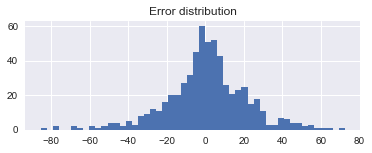

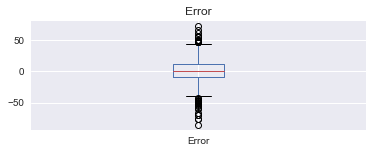

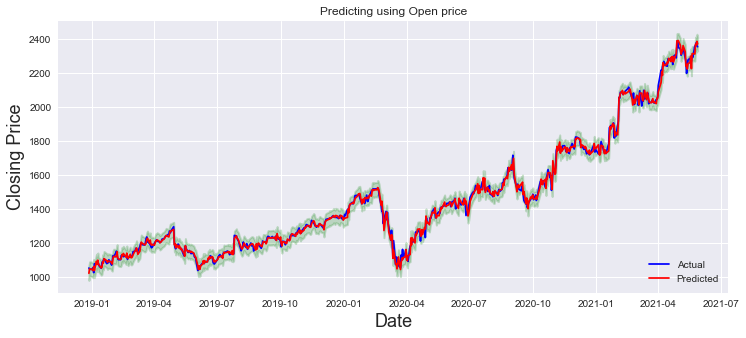

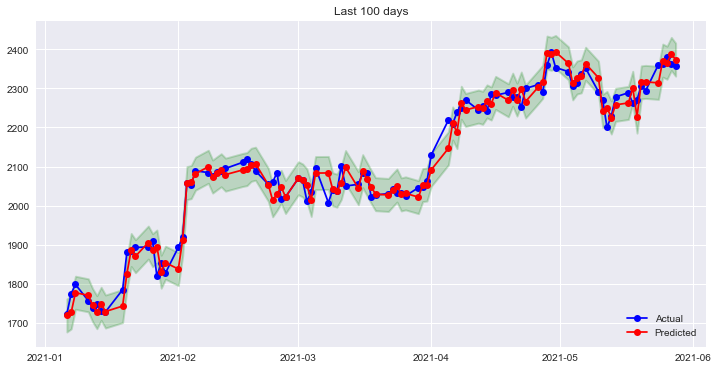

In [32]:
plot_model_prediction(df['Actual price'], df['Predicted 1'], idx=df.index, 
                      title = 'Predicting using Open price', eval_error=True, 
                      zoom_in=[-100,None], zoom_title='Last 100 days')

Comparing metric:
 - MAPE: 1.3246458112894877 %
 - MAE: 19.096077225971356
Error.describe:
count    610.000000
mean       0.452033
std       28.237203
min     -142.384479
25%      -11.181931
50%        0.583478
75%       13.197848
max      137.634570
Name: Error, dtype: float64


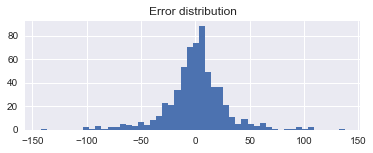

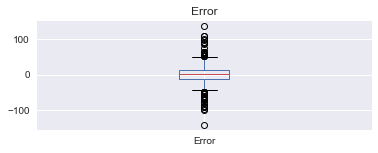

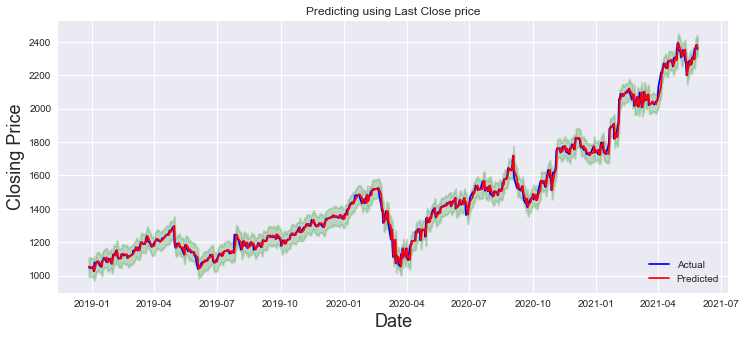

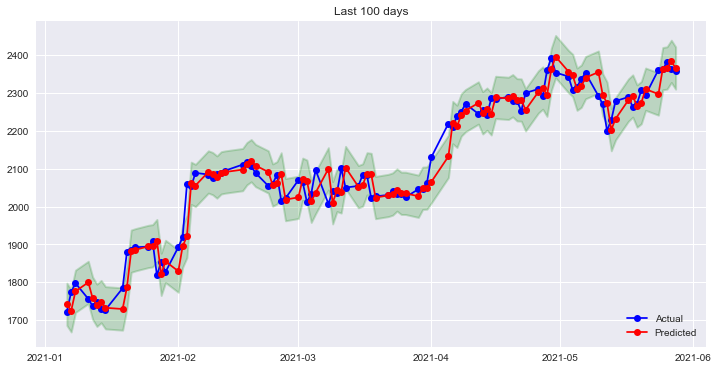

In [42]:
plot_model_prediction(df['Actual price'], df['Predicted 2'], idx=df.index, 
                      title = 'Predicting using Last Close price', eval_error=True,
                      zoom_in=[-100,None], zoom_title='Last 100 days')

Tương tự ta có thể áp dụng trên một số stock khác:

 - AAPL

In [34]:
apple_df = data[data[const_name_col] == 'AAPL']
apple_processed_df = cal_features(apple_df, norm_func=StandardScaler(), next_t=1, re_fit=True)
apple_train_data, apple_test_data = train_test_split(apple_processed_df, test_size=0.15, shuffle=False)

In [35]:
apple_model1 = Open_HMM_Model(n_components = 5)
apple_model1.fit(apple_train_data)
apple_pred1 = apple_model1.predict(apple_test_data, w_len = 10)

apple_model2 = LastClose_HMM_Model(n_components = 4)
apple_model2.fit(apple_train_data)
apple_pred2 = apple_model2.predict(apple_test_data, w_len = 10)

apple_df = pd.DataFrame(list(zip(apple_test_data['Close'][10:], apple_pred1, apple_pred2)), \
                  columns =['Actual price', 'Predicted 1', 'Predicted 2'], index=apple_test_data[10:].index)

[==========================================================] 100% Time: 0:14:26
[==========================================================] 100% Time: 0:14:29


Comparing metric:
 - MAPE: 1.215848927004485 %
 - MAE: 1.0610153690122794
Error.describe:
count    610.000000
mean       0.020542
std        1.545341
min       -6.152933
25%       -0.562573
50%        0.063269
75%        0.745585
max        5.568166
Name: Error, dtype: float64


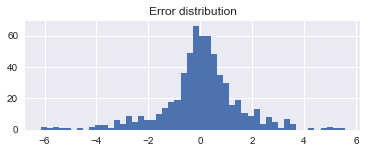

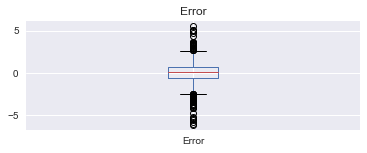

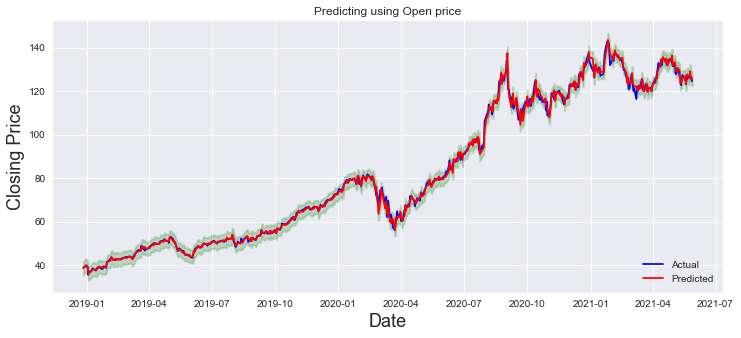

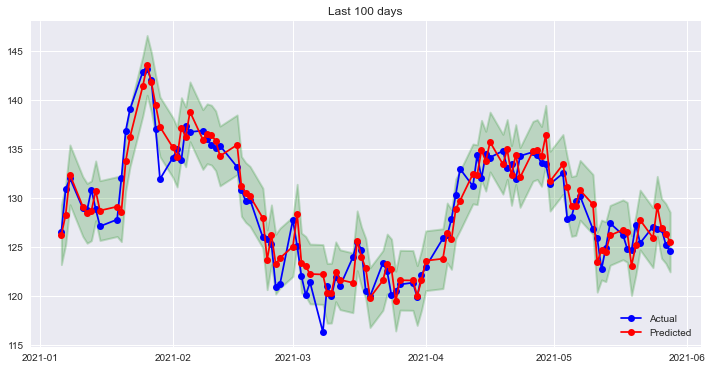

In [36]:
plot_model_prediction(apple_df['Actual price'], apple_df['Predicted 1'], idx=apple_df.index, 
                      title = 'Predicting using Open price', eval_error=True, 
                      zoom_in=[-100,None], zoom_title='Last 100 days')

Comparing metric:
 - MAPE: 1.5716997053963517 %
 - MAE: 1.3281031026575085
Error.describe:
count    610.000000
mean       0.044313
std        2.005614
min      -10.665515
25%       -0.720697
50%        0.034951
75%        0.896404
max        9.957394
Name: Error, dtype: float64


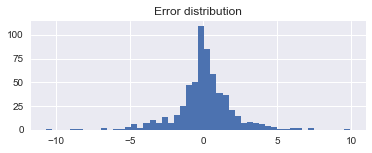

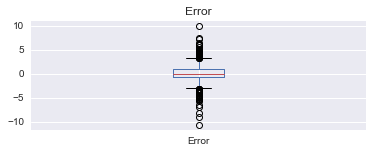

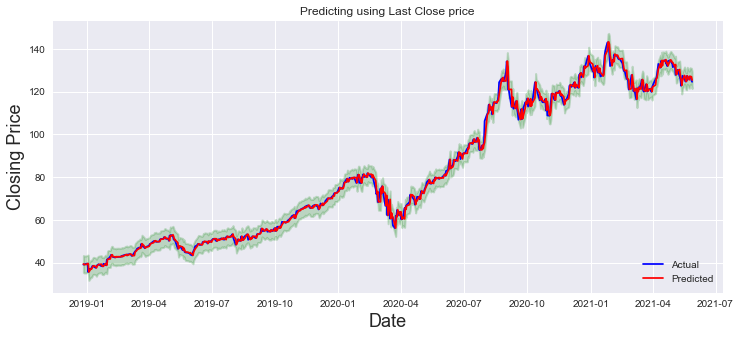

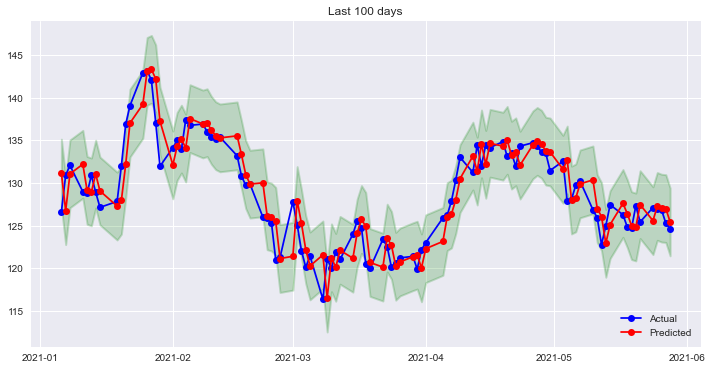

In [43]:
plot_model_prediction(apple_df['Actual price'], apple_df['Predicted 2'], idx=apple_df.index, 
                      title = 'Predicting using Last Close price', eval_error=True, 
                      zoom_in=[-100,None], zoom_title='Last 100 days')

 - GME

In [38]:
gme_df = data[data[const_name_col] == 'GME']
gme_processed_df = cal_features(gme_df, norm_func=StandardScaler(), next_t=1, re_fit=True)
gme_train_data, gme_test_data = train_test_split(gme_processed_df, test_size=0.15, shuffle=False)

In [39]:
gme_model1 = Open_HMM_Model(n_components = 5)
gme_model1.fit(gme_train_data)
gme_pred1 = apple_model1.predict(gme_test_data, w_len = 10)

gme_model2 = LastClose_HMM_Model(n_components = 4)
gme_model2.fit(gme_train_data)
gme_pred2 = apple_model2.predict(gme_test_data, w_len = 10)

gme_df = pd.DataFrame(list(zip(gme_test_data['Close'][10:], gme_pred1, gme_pred2)), \
                  columns =['Actual price', 'Predicted 1', 'Predicted 2'], index=apple_test_data[10:].index)

[==========================================================] 100% Time: 0:14:28
[==========================================================] 100% Time: 0:13:58


Comparing metric:
 - MAPE: 4.58046213249318 %
 - MAE: 2.4516407040127763
Error.describe:
count    610.000000
mean      -0.115058
std        9.036188
min      -87.997812
25%       -0.155383
50%        0.031950
75%        0.246295
max       61.649610
Name: Error, dtype: float64


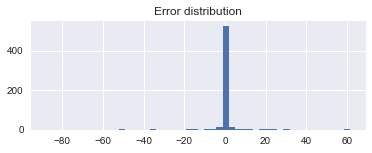

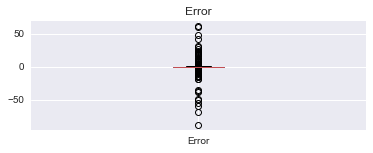

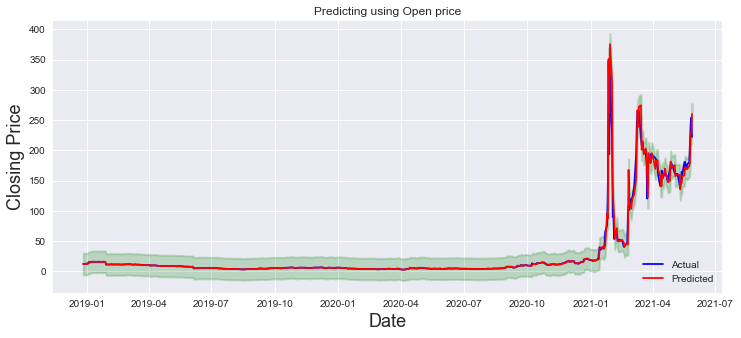

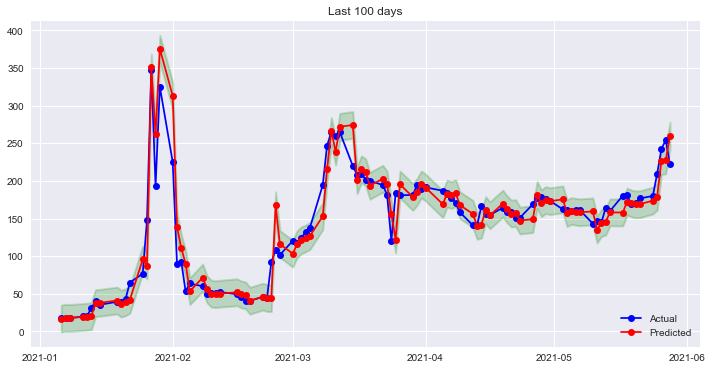

In [40]:
plot_model_prediction(gme_df['Actual price'], gme_df['Predicted 1'], idx=gme_df.index, 
                      title = 'Predicting using Open price', eval_error=True, 
                      zoom_in=[-100,None], zoom_title='Last 100 days')

Comparing metric:
 - MAPE: 5.361398404306387 %
 - MAE: 3.173499508870524
Error.describe:
count    610.000000
mean       0.313163
std       15.334848
min     -154.228949
25%       -0.184953
50%       -0.026857
75%        0.186077
max      199.394198
Name: Error, dtype: float64


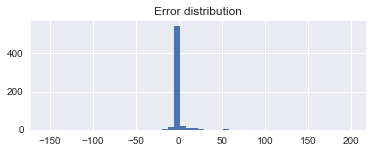

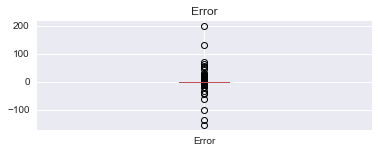

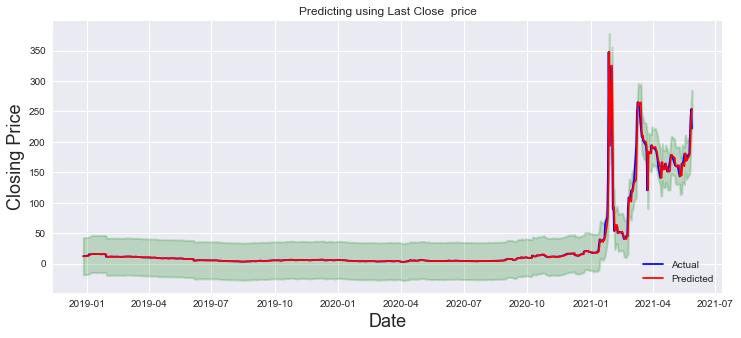

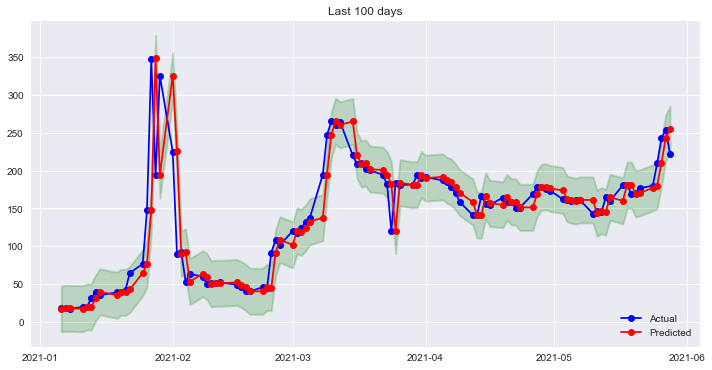

In [44]:
plot_model_prediction(gme_df['Actual price'], gme_df['Predicted 2'], idx=gme_df.index, 
                      title = 'Predicting using Last Close  price', eval_error=True, 
                      zoom_in=[-100,None], zoom_title='Last 100 days')

# 5. Nguồn tham khảo

[1] https://insights.magestore.com/posts/giai-thuat-time-series-forecasting

[2] https://hmmlearn.readthedocs.io/en/latest/tutorial.html

[3] http://www.cs.cmu.edu/~bdhingra/papers/stock_hmm.pdf
